In [182]:
%run functions.py
%run plot_functions.py

import numpy as np
import pandas as pd
from scipy.io import loadmat
from copy import deepcopy
import matplotlib.pyplot as plt
from itertools import product

from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

## Load settings

In [183]:
pd.set_option('display.max_colwidth',-1)

k=10 # Define k for crossvalidation
seed = 42 # Seed to use

score_function = f_classif # Score function for Feature selection
feature_tot = 0 # Total selected features -> Start at 0 before PCA
scoring='accuracy' # Scoring method for GridsearchCV

np.random.seed(seed) # Define the random seed


# Task 4 - Classification 

## Load dataset

In [184]:
filename = "datasets/thyroidTrain.mat"

mat = loadmat(filename)
input_train = mat['trainThyroidInput']

target_train = mat['trainThyroidOutput']
input_test = mat['testThyroidInput']

## Data info

In [185]:
# The shape should look like (401,133) where 401 is the number of features and 133 is each row
print("Length of",len(input_train))
print("X.shape:", input_train.shape, "y.shape:", target_train.shape)    
print("Contains Nan:",np.isnan(input_train).any(), np.isnan(target_train).any())
print("Contains +inf:",np.isinf(input_train).any(),np.isinf(target_train).any())
print("Contains -inf:",np.isneginf(input_train).any(),np.isneginf(target_train).any())
#pd.DataFrame(input_train).describe()

Length of 5000
X.shape: (5000, 21) y.shape: (5000, 3)
Contains Nan: False False
Contains +inf: False False
Contains -inf: False False


## Preprocess
Normalize the dataset

In [186]:
input_train_copy = deepcopy(input_train)

# In case one-hot'
if len(target_train.T) == 3:

    print("One hot --> single value output")
    rows, cols = np.where(target_train == 1)
    target_train = cols
                         
                                  
print(len(target_train.T))
# Normalizing data
scaler = StandardScaler()
scaler.fit(input_train,y=target_train)

input_train_copy_normalized = deepcopy(input_train_copy)

input_train = scaler.transform(input_train)
input_test = scaler.transform(input_test)

One hot --> single value output
5000


## Feature reduction
Reduce dimensionality by PCA transform

In [187]:
pca = PCA(n_components = .95, svd_solver = 'full')
pca.fit(input_train,y=input_train)

pca_input = pca.transform(input_train)

feature_tot = len(pca_input[0])
print("original shape:   ", input_train_copy.shape)
print("transformed shape:", pca_input.shape)
print("Explained variance:",pca.explained_variance_ratio_)

original shape:    (5000, 21)
transformed shape: (5000, 19)
Explained variance: [0.11644462 0.07693855 0.06624585 0.05484826 0.05400037 0.05290859
 0.04951334 0.04840626 0.04679861 0.04582658 0.04538423 0.04431255
 0.04244733 0.04194532 0.04107869 0.04019269 0.03850317 0.03597675
 0.03242482]


# Plot PCA

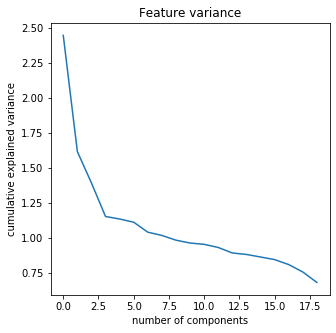

In [188]:
from math import ceil

cntItems = 1
rowItems = 1
fig, ax = plt.subplots(cntItems,rowItems,figsize=(5,5))

if cntItems == 1: axlist = range(rowItems)
else: axlist = list(product(range(cntItems),range(rowItems)))

# Plot feature variance
plt.title("Feature variance")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
feature_variance = np.var(pca_input, 0)
plt.plot(feature_variance)

plt.show()



## Plot top 10 histogram over reduced features

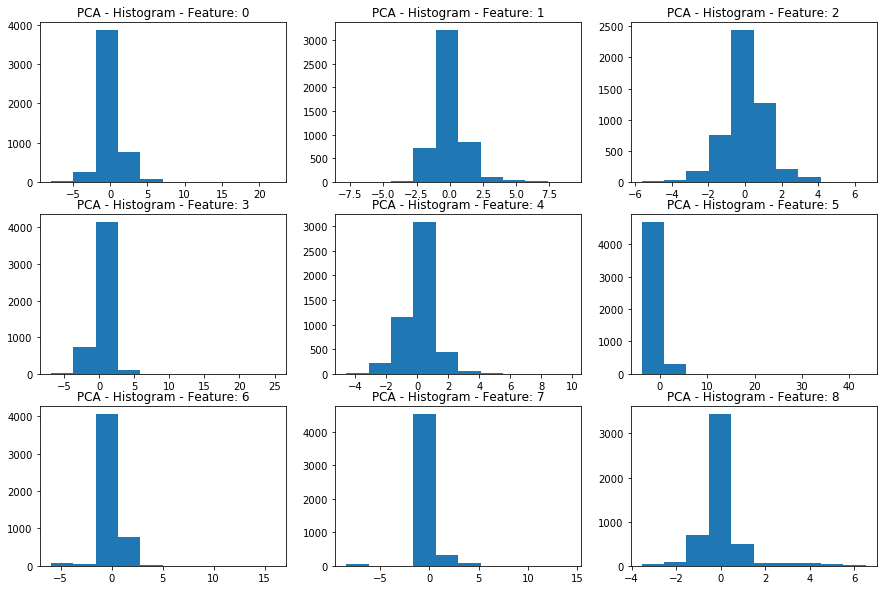

In [189]:
from math import ceil
startpos = 1
cntPlots = length if (length := feature_tot) <= 9 else 9
rowItems = 3
cntItems = ceil(cntPlots/rowItems)

fig, ax = plt.subplots(cntItems,rowItems,figsize=(15,10))
if cntItems == 0: axlist = range(rowItems)
else: axlist = list(product(range(cntItems),range(rowItems)))


for index in range(0,(cntPlots)):
    ax[axlist[index]].set_title("PCA - Histogram - Feature: " + str(index))
    ax[axlist[index]].hist(pca_input[:,index])
    
plt.show()

# Feature selection
Extract top features above depending on PCA

(5000, 21)


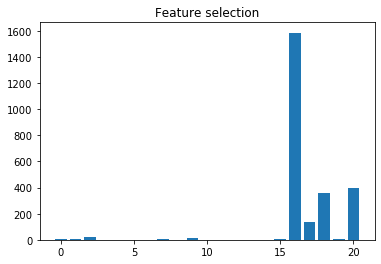

In [190]:
# Using amount of features based on PCA information
fs = SelectKBest(score_func=score_function, k=feature_tot)
fs.fit(input_train, target_train)
input_train_fs = fs.transform(input_train)
input_test_fs = fs.transform(input_test)

print(input_train_fs.shape)
plt.title("Feature selection")
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

## Hyperparameter tuning

In [191]:
#https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/


from sklearn.linear_model import Lasso,ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve,validation_curve

N_FEATURES_COMPONENT = np.arange(2,10,2)

feature_select = [
        #PCA(iterated_power=N_FEATURES_COMPONENT), 
        #SelectKBest(f_regression),
        #ExtraTreesRegressor(random_state=seed, n_estimators=250),
        #RFE(RandomForestRegressor())
    ]


# GridSearchCV
estimators = [
    #('reduce_dim','passthrough'),
    ('clf', LinearSVC()),
]
param_grid = [
    {
        #'reduce_dim': feature_select,
        'clf':[LinearSVC()],
        'clf__penalty':['l1','l2'],
        'clf__C': [0.1,0.5,1,1.5,2.0],
        'clf__dual':[True,False]
    },{
        #'reduce_dim': feature_select,
        'clf':[KNeighborsClassifier()],
        'clf__n_neighbors':[5,3,6,8],
        'clf__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
        'clf__leaf_size':[30,15,20,40]
    },{
        #'reduce_dim': feature_select,
        'clf':[SVC()],
        'clf__C':[1,0.5,1,5.2],
        'clf__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
        'clf__degree':[1,2,3],
        'clf__gamma':['scale', 'auto'],
        'clf__max_iter':[-1,1000,5000,10000],
}]


pipeline = Pipeline(estimators)
grid = GridSearchCV(
    pipeline,
    cv=k, 
    param_grid=param_grid,
    return_train_score=True,
    refit=True,
    n_jobs=-1,
    scoring=scoring
) 
grid.fit(input_train_fs,target_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('clf',
                                        LinearSVC(C=1.0, class_weight=None,
                                                  dual=True, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  loss='squared_hinge',
                                                  max_iter=1000,
                                                  multi_class='ovr',
                                                  penalty='l2',
                                                  random_state=None, tol=0.0001,
                                                  verbose=0))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'clf': [LinearSVC(C=1.0, c...
                                      gamma='scale', kernel='rbf', max_iter=-1,
  

## Get Model info

In [192]:
param_cols = ['']
score_cols = ['mean_train_score', 'std_test_score','mean_test_score', 'std_test_score']

grid_df = pd.DataFrame(grid.cv_results_, columns=score_cols)
grid_df.sort_values(by=['mean_test_score']).tail()
#print(grid_df)

print(f"Best score: {grid.best_score_}\nBest params {grid.best_params_}")

Best score: 0.969
Best params {'clf': SVC(C=5.2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'clf__C': 5.2, 'clf__degree': 1, 'clf__gamma': 'scale', 'clf__kernel': 'rbf', 'clf__max_iter': -1}


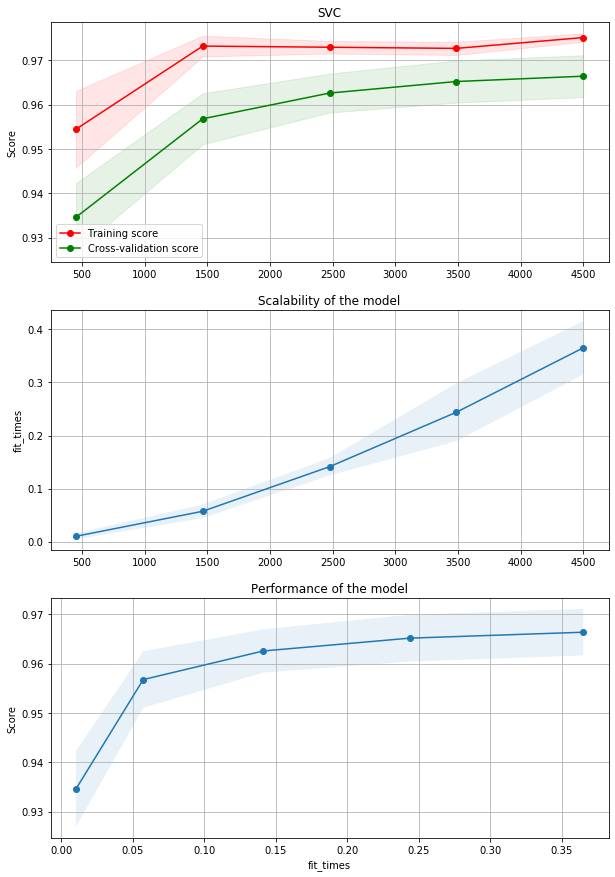

In [193]:
# Parameter to
param_range = np.arange(0.01, 50,5)
model = grid.best_params_['clf']
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
plot_learning_curve(model, model.__class__.__name__, input_train, target_train, axes=axes[:], cv=k, scoring=scoring, n_jobs=-1)
plt.show()

# Predict testset

In [194]:
model = grid.best_params_['clf']
model.fit(input_train_fs, target_train)
model.predict(input_test_fs)

array([2, 2, 2, ..., 1, 2, 0])